In [1188]:
# Importing numpy, pandas, math and matplotlib libraries and setting default fonts

import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.image as image
from matplotlib import artist
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Franklin Gothic Medium', 'Franklin Gothic Book']

In [1189]:
# Importing necessary data tables as Pandas DataFrames

passing_rough = pd.read_excel(r'C:\Users\aaron\Documents\ET5L end of Season\Passing Stats.xlsx')
possession_rough = pd.read_excel(r'C:\Users\aaron\Documents\ET5L end of Season\Possession Stats.xlsx')

In [1190]:
# Removing all players with less than 900 minutes

nineties_passing = passing_rough['90s'] >= 10
passing_filtered = passing_rough[nineties_passing].set_index('Player')

nineties_possession = possession_rough['90s'] >= 10
possession_filtered = possession_rough[nineties_possession].set_index('Player')

In [1191]:
# Fixing names of players with multiple clubs, or players with identical names

passing_filtered.index = passing_filtered.index.where(~passing_filtered.index.duplicated(),\
                                                      passing_filtered.index + " (" + passing_filtered['Squad'] + ")")
possession_filtered.index = possession_filtered.index.where(~possession_filtered.index.duplicated(),\
                                                      possession_filtered.index + " (" + passing_filtered['Squad'] + ")")

In [1192]:
# Removing all non-midfielders

passing_position = passing_filtered['Pos'].str.startswith('MF')
passing_fullfilter = passing_filtered[passing_position]

possession_position = possession_filtered['Pos'].str.startswith('MF')
possession_fullfilter = possession_filtered[possession_position]

In [1193]:
# Features needed for percentile chart

passing_features = ['Squad', '90s', 'Cmp%', 'PrgDist', '1/3', 'Prog']
possession_features = ['Player/Club', 'Squad', '90s', 'SuccDrb', 'Succ%Drb', 'PrgDistCarry', 'Miscon', 'Dispos']

passing_absolute = passing_fullfilter[passing_features]
possession_absolute = possession_fullfilter[possession_features]

In [1194]:
# Generate Percentiles DataFrame

passing_percentiles = pd.DataFrame()
passing_percentiles['Squad'] = passing_absolute['Squad']
passing_percentiles['Pass\nComp %'] = passing_absolute['Cmp%'].rank(pct=True)*100
passing_percentiles['Progressive Pass/Carry\nYards p90'] = \
    ((passing_absolute['PrgDist']+possession_absolute['PrgDistCarry'])/ \
     passing_absolute['90s']).rank(pct=True)*100
passing_percentiles['Passes into\nFinal Third\np90'] = \
    (passing_absolute['1/3']/passing_absolute['90s']).rank(pct=True)*100
passing_percentiles['Progressive\nPasses p90'] = \
    (passing_absolute['Prog']/passing_absolute['90s']).rank(pct=True)*100
passing_percentiles['Rate Adj Successful\nDribbles p90'] =\
    (possession_absolute['SuccDrb']*possession_absolute['Succ%Drb']/ \
    possession_absolute['90s']).rank(pct=True)*100
passing_percentiles['Miscontrols+\nDispossessions\np90'] =\
    ((possession_absolute['Miscon']+possession_absolute['Dispos'])/ \
     possession_absolute['90s']).rank(pct=True, ascending=False)*100
passing_percentiles['Player/Club'] = possession_absolute['Player/Club']

In [1195]:
team_colour = pd.read_csv(r'C:\Users\aaron\Documents\club colours.csv')

In [1196]:
def directory(squad_name):
    '''Returns directory of all players that play in a given club.
    
    Args:
        squad_name: A string containing the name of any club in Europe's Top 5 Leagues.
    
    Returns:
        A Pandas DataFrame with all players such that passing_percentiles[squad_name] == squad_name
        
    Raises:
        Traceback: If squad_name is not a string under passing_percentiles['Squad']
    '''
    
    players = passing_percentiles['Squad'] == squad_name
    return passing_percentiles[players]

In [1197]:
def label_adjuster(i):
    
    '''Adjusts labels in percentile polar axis charts given value between 0 and 100
    
    Args:
        i: Any float such that 0 <= i <= 100
    
    Returns:
        Integer 10 if i <= 50, or integer -10 if i > 50
    
    Example: label_adjuster(51.0) -> -10
    '''
    
    if i <= 50:
        return 10
    else:
        return -10

def percentile_chart(player_name):
    '''Creates a percentile chart based on a player's percentile rankings in various metrics
    using passing_percentiles
    
    Args:
        player_name: A string containing the name of a player in the indeces of passing_percentiles
    
    Returns:
        Passing percentile chart for player_name
    
    Raises:
        Traceback: If player_name is not a string in the indeces of passing_percentiles
    
    '''
    
    # Creates bars based on the player entered
    theta = list(map((lambda x: x*math.pi/6), list(range(1,13,2))))
    radii = list(passing_percentiles.loc[player_name][1:7])
    width = [math.pi/3]*len(radii)
    
    # Aesthetic details of the figure including color, axis tick size, x value specifics
    # and r-axis limits, etc.
    plt.figure(figsize=(10,10), facecolor = '#0b0d0f')
    ax = plt.subplot(111, projection='polar')
    ax.set_facecolor('#171b1e')
    ax = plt.subplot(111, projection='polar')
    ax.grid(True, color='#2e353c')
    ax.tick_params(axis='x', colors='xkcd:off white')
    ax.tick_params(axis='y', colors='xkcd:off white')
    ax.set_rlim(0,100)
    ax.spines['polar'].set_color('xkcd:off white')
    ax.spines['polar'].set_linewidth(3)
    ax.set_rlabel_position(0)
    ax.set_rticks([20,40,60,80,100])
    ax.tick_params(labelsize=14)
    labels = plt.thetagrids(range(0,360,60), ('','','','','',''))
    ax.spines['polar'].set_color('xkcd:off white')
    ax.spines['polar'].set_linewidth(3)
    
    # Aesthetic details of the bars and chart titles based on player name
    ax.bar(theta, radii, width, color=list(team_colour[passing_percentiles.at[player_name, 'Squad']])[0], \
           alpha=0.6, edgecolor='#2e353c', linewidth=1.5)
    ax.set_title('\n'+player_name+'- Possession Performance Overview\n\n', \
                 color=list(team_colour[passing_percentiles.at[player_name, 'Squad']])[0], fontsize=25)

    l = list(passing_percentiles)
    
    # Adds text to the chart in necessary places
    plt.text(-0.1, -0.075, 'Created by @amonizfootball\nData obtained from FBRef.com', \
         horizontalalignment='left', verticalalignment='top', color='xkcd:off white', \
             transform=ax.transAxes, size='14')
    plt.text(0.5, 1.13, "Percentile Rankings vs Midfielders in Europe's Top 5 Leagues, 2019/20", \
         horizontalalignment='center', verticalalignment='top', color='xkcd:off white', size='18', \
             transform=ax.transAxes)
    plt.text(1.1, -0.075, '\nExcludes players with <900 minutes', \
         horizontalalignment='right', verticalalignment='top', color='xkcd:off white', \
             style='italic', transform=ax.transAxes, size='14')
    plt.text(1, 0.8, l[1], \
         horizontalalignment='center', verticalalignment='top', color='xkcd:off white', \
             transform=ax.transAxes, size='14',)
    plt.text(0.5, 1.04, l[2], \
         horizontalalignment='center', verticalalignment='center', color='xkcd:off white',\
             transform=ax.transAxes, size='14',)
    plt.text(0, 0.8, l[3], \
         horizontalalignment='center', verticalalignment='center', color='xkcd:off white',\
             transform=ax.transAxes, size='14')
    plt.text(0, 0.2, l[4], \
         horizontalalignment='center', verticalalignment='center', color='xkcd:off white',\
             transform=ax.transAxes, size='14')
    plt.text(0.5, -0.03, l[5], \
         horizontalalignment='center', verticalalignment='center', color='xkcd:off white',\
             transform=ax.transAxes, size='14')
    plt.text(1, 0.2, l[6], \
         horizontalalignment='center', verticalalignment='center', color='xkcd:off white',\
             transform=ax.transAxes, size='14')
    
    # Annotating bar labels with their values
    for i in [0,1,2,3,4,5]:
        plt.annotate(str(int(round(radii[i])))+"%", (theta[i], radii[i]+label_adjuster(radii[i])), color='xkcd:off white', \
                horizontalalignment='center', fontsize=14)
    
    plt.show()

In [1227]:
directory('Paris S-G')

,Squad,Pass\nComp %,Progressive Pass/Carry\nYards p90,Passes into\nFinal Third\np90,Progressive\nPasses p90,Rate Adj Successful\nDribbles p90,Miscontrols+\nDispossessions\np90,Player/Club
Player,,,,,,,,
Idrissa Gana Gueye,Paris S-G,98.908730,97.222222,96.031746,92.063492,56.944444,69.047619,Idrissa Gana Gueye (Paris S-G)
Marco Verratti,Paris S-G,99.404762,100.000000,100.000000,99.007937,79.563492,72.817460,Marco Verratti (Paris S-G)
Marquinhos,Paris S-G,99.801587,98.412698,92.063492,65.873016,27.777778,96.825397,Marquinhos (Paris S-G)
Neymar,Paris S-G,42.063492,99.206349,96.230159,99.801587,100.000000,0.198413,Neymar (Paris S-G)


C:\Users\aaron\anaconda3\lib\site-packages\ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


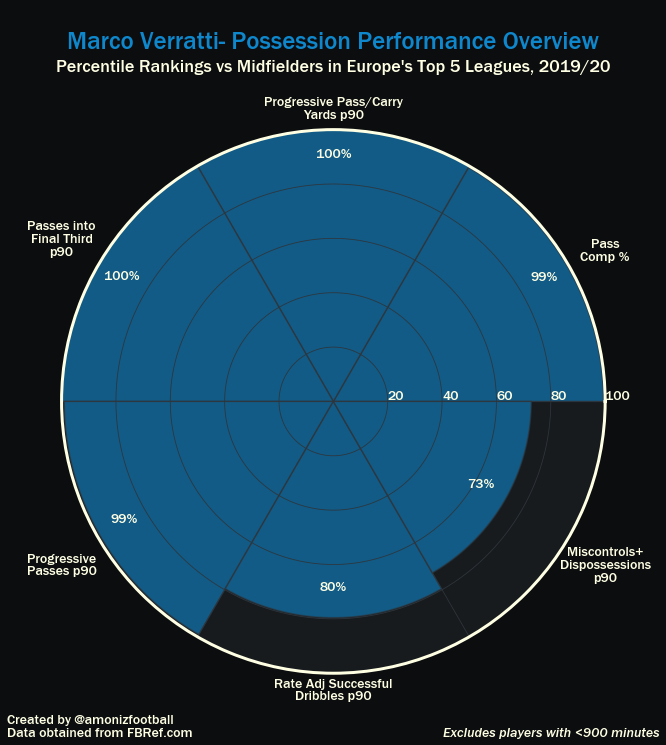

In [1225]:
percentile_chart('Marco Verratti')